In [11]:

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import argparse

for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))


: /physical_device:CPU:0


In [12]:

#2. Configuration and Data Path Setup
# Configuration parameters
IMAGE_SIZE = (224, 224)  # Reduced size for faster training
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001
N_CLASSES = 2

def get_dataset_path():
    """Get dataset path from command line argument or use default"""
    try:
        parser = argparse.ArgumentParser(description='Wildfire Detection Model')
        parser.add_argument('--dataset_path', type=str, default=r'C:\Users\Admin\Desktop\home files\PATHWAYS\Wildfire Prediction Model\archive (3)',
                          help='Path to the wildfire dataset')
        args, _ = parser.parse_known_args()
        return args.dataset_path
    except:
        # Default path if no argument is provided
        return r'C:\Users\Admin\Desktop\home files\PATHWAYS\Wildfire Prediction Model\archive (3)'


In [13]:
dataset_path = get_dataset_path()

train_path = os.path.join(dataset_path, 'train')
valid_path = os.path.join(dataset_path, 'validation')  
test_path = os.path.join(dataset_path, 'test')

print(f"Dataset path: {dataset_path}")
print(f"Train path: {train_path}")
print(f"Validation path: {valid_path}")
print(f"Test path: {test_path}")

for path in [train_path, valid_path, test_path]:
    if os.path.exists(path):
        print(f"✓ {path} exists")
        classes = os.listdir(path)
        print(f"  Classes found: {classes}")
        for class_name in classes:
            class_path = os.path.join(path, class_name)
            if os.path.isdir(class_path):
                num_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
                print(f"  {class_name}: {num_images} images")
    else:
        print(f"✗ {path} does not exist")


Dataset path: C:\Users\Admin\Desktop\home files\PATHWAYS\Wildfire Prediction Model\archive (3)
Train path: C:\Users\Admin\Desktop\home files\PATHWAYS\Wildfire Prediction Model\archive (3)\train
Validation path: C:\Users\Admin\Desktop\home files\PATHWAYS\Wildfire Prediction Model\archive (3)\validation
Test path: C:\Users\Admin\Desktop\home files\PATHWAYS\Wildfire Prediction Model\archive (3)\test
✓ C:\Users\Admin\Desktop\home files\PATHWAYS\Wildfire Prediction Model\archive (3)\train exists
  Classes found: ['nowildfire', 'wildfire']
  nowildfire: 14500 images
  wildfire: 15750 images
✗ C:\Users\Admin\Desktop\home files\PATHWAYS\Wildfire Prediction Model\archive (3)\validation does not exist
✓ C:\Users\Admin\Desktop\home files\PATHWAYS\Wildfire Prediction Model\archive (3)\test exists
  Classes found: ['nowildfire', 'wildfire']
  nowildfire: 2820 images
  wildfire: 3480 images


In [14]:

CLASS_NAMES = ['nowildfire', 'wildfire']
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    dtype='float32'
)


In [15]:

valid_test_datagen = ImageDataGenerator(rescale=1./255, dtype='float32')
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=True
)

valid_generator = valid_test_datagen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False
)

test_generator = valid_test_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {valid_generator.samples}")
print(f"Test samples: {test_generator.samples}")


Found 30250 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Training samples: 30250
Validation samples: 0
Test samples: 6300


In [16]:

weight_decay = 1e-4  

model = Sequential([
    #First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same', 
           input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
           kernel_regularizer=regularizers.l2(weight_decay)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(weight_decay)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    #second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(weight_decay)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(weight_decay)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    #third convolutional block
    Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(weight_decay)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(N_CLASSES, activation='softmax')
])


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,02

 Total params: 51,656,354 (197.05 MB)

 Trainable params: 51,654,178 (197.05 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [18]:

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

checkpointer = ModelCheckpoint('wildfire_model_best.h5', verbose=1, 
                              save_best_only=True, monitor='val_accuracy')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, 
                              restore_best_weights=True, verbose=1)
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', 'AUC', 'Precision', 'Recall']
)


In [19]:

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print(f"Class weights: {class_weights}")


Class weights: {0: np.float64(1.043103448275862), 1: np.float64(0.9603174603174603)}


In [20]:

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    verbose=1,
    validation_data=valid_generator,
    callbacks=[checkpointer, early_stopping],
    class_weight=class_weights
)


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
 63/946 ━━━━━━━━━━━━━━━━━━━━ 1:27:42 6s/step - AUC: 0.8965 - Precision: 0.8162 - Recall: 0.8162 - accuracy: 0.8162 - loss: 0.6992

KeyboardInterrupt: 

NameError: name 'history' is not defined

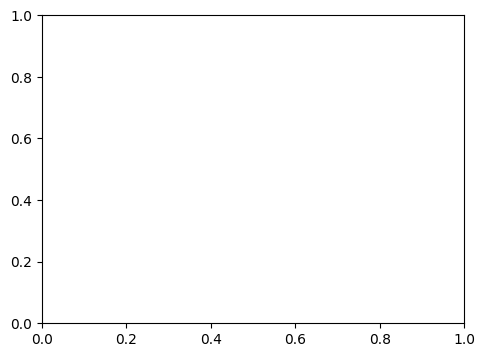

In [21]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [22]:

test_results = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test AUC: {test_results[2]:.4f}")


197/197 ━━━━━━━━━━━━━━━━━━━━ 172s 872ms/step - AUC: 0.5524 - Precision: 0.5524 - Recall: 0.5524 - accuracy: 0.5524 - loss: 3.1760
Test Loss: 3.1760
Test Accuracy: 0.5524
Test AUC: 0.5524


In [23]:

model.save('wildfire_detection_model_final.h5')
print("Model saved as 'wildfire_detection_model_final.h5'")


Model saved as 'wildfire_detection_model_final.h5'


In [24]:


def predict_wildfire(image_path, model):
    """Predict if an image contains wildfire"""

    img = load_img(image_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    
    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction)
    confidence = prediction[0][class_idx]

    class_name = CLASS_NAMES[class_idx]
    return class_name, confidence


In [29]:

#Example usage:
result, confidence = predict_wildfire('C:\Users\Admin\Desktop\home files\PATHWAYS\Wildfire Prediction Model\archive (3)\test\nowildfire\-73.602,45.421799.jpg', model)
print(f"Prediction: {result} (Confidence: {confidence:.2f})")
model.save('wildfire_model.h5')

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (1864266322.py, line 2)